<h1><center>Hand Posture Classifiers</center></h1>

<h3><center>Logistic Regression, Decision Tree Classifier, Gaussian Naïve Bayes, K-Nearest Neighbours</center></h3>

---

The purpose of this project is to produce the best classifier using exclusively linear, tree-based, naïve Bayes and K-nearest neighbours algorithms on a real-world dataset. The latter contains 78095 instances on 14 distinct users corresponding to a single frame of a hand posture recorded by a camera system. Each record is associated with a particular class of hand posture, which can range from 1 to 5 and constitutes our target variable. The dataset features consist of x, y and z coordinates of the *i*-th unlabeled marker position on glove fingers in a motion capture environment, with i ranging from 0 to 11. In addition, the ‘User’ variable is present in the dataset, but it has no meaning other than acting as an identifier. This dataset was adapted from the [Motion Capture Hand Postures data] (https://archive.ics.uci.edu/dataset/405/motion+capture+hand+postures).

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, matthews_corrcoef,  ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Exploratory Data Analysis

In [2]:
df = pd.read_csv("postures.csv")
df = df.drop(0)
df.shape

(78095, 38)

In [3]:
len(df['User'].unique())

14

In [4]:
# Converting to numeric data type
coerced_cols = df.loc[:, ~df.columns.isin(['Class', 'User'])].apply(lambda p: pd.to_numeric(p, errors='coerce'))
df = pd.concat([df[['User', 'Class']], coerced_cols], axis=1)

In [5]:
# Calculating counts and percentages of missing values
missing_percentage = (df.isna().mean() * 100).round(2)
missing_counts = df.isna().sum()
missing_info_df = pd.DataFrame({'Variable': missing_percentage.index, 
                                'Missing Value Count': missing_counts.values,
                                'Missing Value Percentage': missing_percentage.values})
missing_info_df

,Variable,Missing Value Count,Missing Value Percentage
0,User,0,0.00
1,Class,0,0.00
2,X0,0,0.00
3,Y0,0,0.00
4,Z0,0,0.00
5,X1,0,0.00
6,Y1,0,0.00
7,Z1,0,0.00
8,X2,0,0.00
9,Y2,0,0.00


In [6]:
x, y = df.drop('Class', axis=1), df['Class']
x.columns = x.columns.astype(str)

# Evaluating class balance
x_array = np.array(x)
y_class = np.array(y)
vals, counts= np.unique(y_class, return_counts=True)
for v, c in zip(vals, counts):
    print(v, "--->", c)

1 ---> 16265
2 ---> 14978
3 ---> 16344
4 ---> 14775
5 ---> 15733


In [7]:
print(f"{len(df[df.duplicated()])} entries are duplicates")

0 entries are duplicates


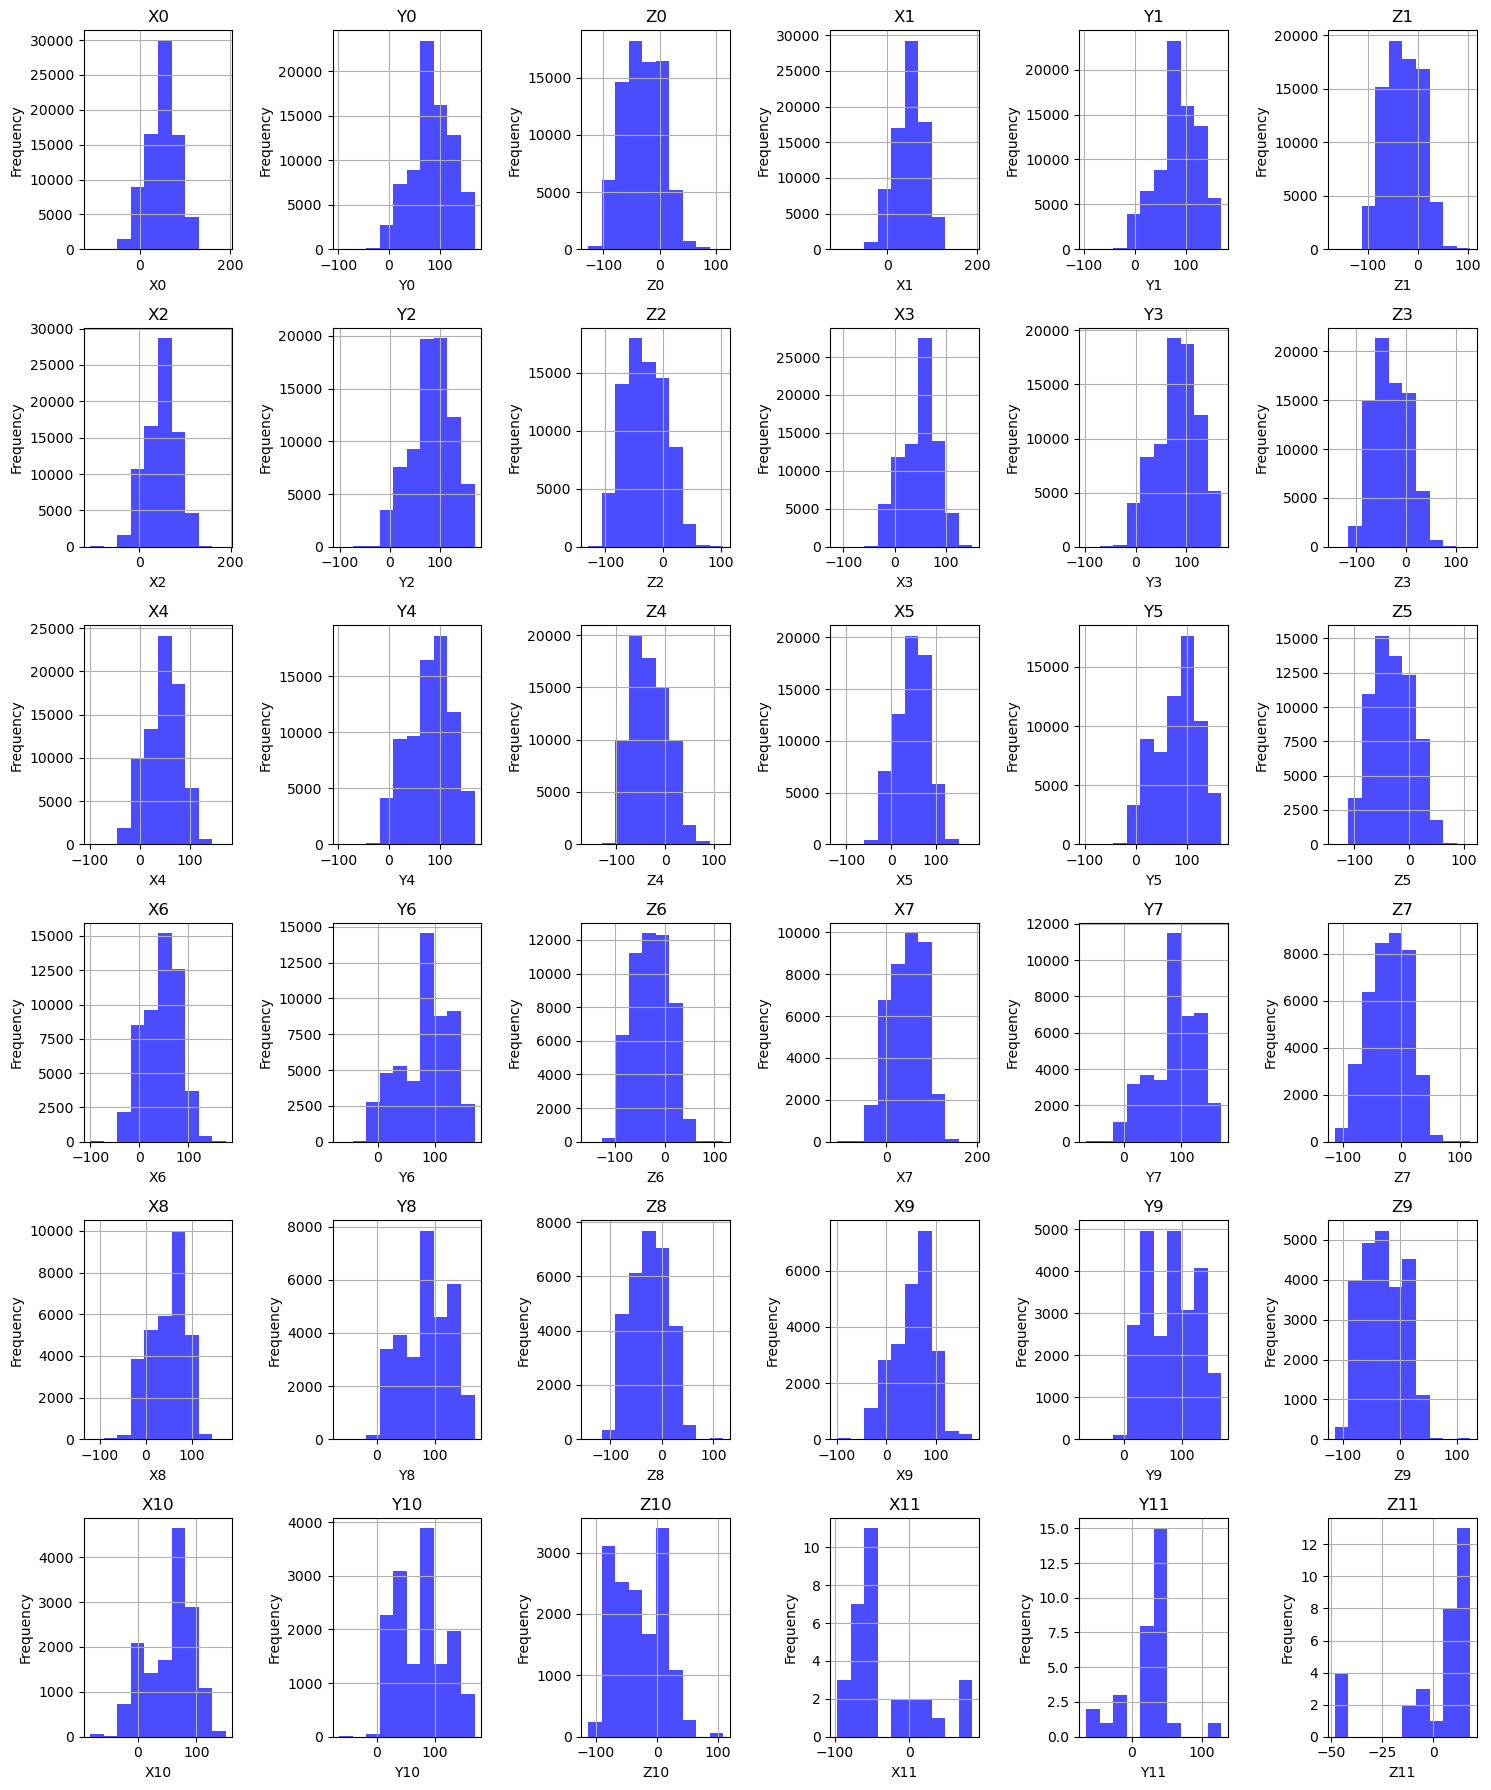

In [8]:
# Plotting frequency distribution of the continuous variables
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(15, 3 * 6))
for i in range(0,36):
    row_index = i // 6
    col_index = i % 6
    column_name = df.columns[i+2]
    df.iloc[:, i+2].hist(ax=axes[row_index, col_index], bins=10, color='blue', alpha=0.7)
    axes[row_index, col_index].set_title(column_name)
    axes[row_index, col_index].set_xlabel(column_name)
    axes[row_index, col_index].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

# Data Pre-Processing Pipeline

In [ ]:
def get_preprocessor(df, scaler, imputer):
    
    numeric_features = list(df.loc[:, ~df.columns.isin(['Class', 'User'])])
    numeric_transformer = Pipeline(steps=[("scaler", scaler), ("imputer", imputer)])

    categorical_features = list(df.loc[:, df.columns.isin(['User'])])
    categorical_transformer = Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])

    return ColumnTransformer(transformers=[("num", numeric_transformer, numeric_features),
                                           ("cat", categorical_transformer, categorical_features)])

In [10]:
def apply_preprocessor(df, scaler, imputer, x_train, x_test, y_train, y_test):
    
    preprocessor = get_preprocessor(df, scaler, imputer)
    xt_train = preprocessor.fit_transform(x_train)
    xt_test = preprocessor.fit_transform(x_test)
    data = (xt_train, y_train, xt_test, y_test)

    return data

In [11]:
def get_preds(data, model):
    
    x_train, y_train, x_test, _ = data
    model.fit(x_train, y_train)
    
    return model.predict(x_test)

In [12]:
def classification_statistics(truth, preds, results):
    
    precision = precision_score(truth, preds, average='macro', zero_division=1)
    recall = recall_score(truth, preds, average='macro')
    f1 = f1_score(truth, preds, average='macro')
    mcc = matthews_corrcoef(truth, preds)
    accuracy = accuracy_score(truth, preds)
    results["Precision"].append(precision)
    results["Recall"].append(recall)
    results["F1"].append(f1)
    results["MCC"].append(mcc)
    results["Accuracy"].append(accuracy)

In [13]:
def model_results(results, model, scaler, imputer, feature_removal='No'):
    
    results['Model'].append(model)
    results['Eliminated Features?'].append(feature_removal)
    results['Scaler'].append(str(scaler))
    results['Imputer'].append(str(imputer))
    
    return results

In [14]:
def create_model_dict():

    model_dict = {"Model": [], "Eliminated Features?": [], "Scaler":[], "Imputer": [], 
                  "Precision": [], "Recall": [], "F1": [], "MCC": [], "Accuracy": []}
    
    return model_dict

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=76)

In [16]:
# Reducing the dataset by eliminating the features that contain more than 70% of missing values
features_to_eliminate = ['X10', 'Y10', 'Z10', 'X11', 'Y11', 'Z11']
x_train_reduced = x_train.drop(columns=features_to_eliminate)
x_test_reduced = x_test.drop(columns=features_to_eliminate)
df_reduced = df.drop(columns=features_to_eliminate)

In [17]:
# Defining the scalers and imputers that will be used
scalers = [StandardScaler(), MinMaxScaler(), PowerTransformer()]
imputers = [SimpleImputer(strategy='constant'), SimpleImputer(strategy='mean'), SimpleImputer(strategy='median')]

# Classification Models

## Logistic Regression

### With all the features

In [18]:
results_log_reg = create_model_dict()

for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df, scaler, imputer, x_train, x_test, y_train, y_test)
        log_reg_model = LogisticRegression(max_iter=100000)
        preds = get_preds(data, log_reg_model)
        classification_statistics(y_test, preds, results_log_reg)
        model_results(results_log_reg, 'Logistic Regression', scaler, imputer, feature_removal='No')

### Only with features containing less than 70% of missing values

In [19]:
for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df_reduced, scaler, imputer, x_train_reduced, x_test_reduced, y_train, y_test)
        preds = get_preds(data, log_reg_model)
        classification_statistics(y_test, preds, results_log_reg)
        model_results(results_log_reg, 'Logistic Regression', scaler, imputer, feature_removal='Yes')

### Combined results from both approaches

In [20]:
results_log_reg_df = pd.DataFrame(results_log_reg)
results_log_reg_df.iloc[[results_log_reg_df['F1'].nlargest(n=3).index[0], 
                         results_log_reg_df['F1'].nlargest(n=3).index[1],
                         results_log_reg_df['F1'].nlargest(n=3).index[2]]]

,Model,Eliminated Features?,Scaler,Imputer,Precision,Recall,F1,MCC,Accuracy
3,Logistic Regression,No,MinMaxScaler(),SimpleImputer(strategy='constant'),0.898365,0.896278,0.895857,0.871199,0.896384
12,Logistic Regression,Yes,MinMaxScaler(),SimpleImputer(strategy='constant'),0.888090,0.885838,0.885219,0.858602,0.886191
1,Logistic Regression,No,StandardScaler(),SimpleImputer(),0.848138,0.848405,0.847884,0.810875,0.848648


## Decision Trees

### With all the features

In [21]:
results_dtc = create_model_dict()
results_dtc['Criterion'] = []
results_dtc['Splitter'] = []
results_dtc['Maximum Depth'] = []
results_dtc['Minimum Samples Leaf'] = []

for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df, scaler, imputer, x_train, x_test, y_train, y_test)              
        for c in ['gini', 'entropy']:
            for s in ['best', 'random']:
                for md in range(1, 11, 2):
                    for msl in range(1, 21, 2):
                        dtc_model = tree.DecisionTreeClassifier(criterion=c, splitter=s, max_depth=md, min_samples_leaf=msl)
                        preds = get_preds(data, dtc_model)
                        classification_statistics(y_test, preds, results_dtc)
                        results_dtc['Criterion'].append(c)
                        results_dtc['Splitter'].append(s)
                        results_dtc['Maximum Depth'].append(md)
                        results_dtc['Minimum Samples Leaf'].append(msl)
                        model_results(results_dtc, 'Decision Tree', scaler, imputer, feature_removal='No')

### Only with features containing less than 70% of missing values

In [22]:
for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df_reduced, scaler, imputer, x_train_reduced, x_test_reduced, y_train, y_test)
        for c in ['gini', 'entropy']:
            for s in ['best', 'random']:
                for md in range(1, 11, 2):
                    for msl in range(1, 21, 2):
                        dtc_model = tree.DecisionTreeClassifier(criterion=c, splitter=s, max_depth=md, min_samples_leaf=msl)
                        preds = get_preds(data, dtc_model)
                        classification_statistics(y_test, preds, results_dtc)
                        results_dtc['Criterion'].append(c)
                        results_dtc['Splitter'].append(s)
                        results_dtc['Maximum Depth'].append(md)
                        results_dtc['Minimum Samples Leaf'].append(msl)
                        model_results(results_dtc, 'Decision Tree', scaler, imputer, feature_removal='Yes')

### Combined results from both approaches

In [23]:
results_dtc_df = pd.DataFrame(results_dtc)
column_order_dtc = [0, 9, 10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8]
results_dtc_df = results_dtc_df.iloc[:, column_order_dtc]
results_dtc_df.iloc[[results_dtc_df['F1'].nlargest(n=3).index[0], 
                     results_dtc_df['F1'].nlargest(n=3).index[1],
                     results_dtc_df['F1'].nlargest(n=3).index[2]]]

,Model,Criterion,Splitter,Maximum Depth,Minimum Samples Leaf,Eliminated Features?,Scaler,Imputer,Precision,Recall,F1,MCC,Accuracy
2141,Decision Tree,entropy,best,9,3,Yes,StandardScaler(),SimpleImputer(),0.892724,0.892827,0.892303,0.866610,0.893157
1940,Decision Tree,entropy,best,9,1,Yes,StandardScaler(),SimpleImputer(strategy='constant'),0.892480,0.892579,0.892035,0.866301,0.892901
2140,Decision Tree,entropy,best,9,1,Yes,StandardScaler(),SimpleImputer(),0.892152,0.892260,0.891713,0.865915,0.892594


## Gaussian Naïve Bayes

### With all the features

In [24]:
results_gnb = create_model_dict()
results_gnb['Alpha'] = []

alphas = np.arange(np.float64(1.00e-10), 2, 0.05)

for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df, scaler, imputer, x_train, x_test, y_train, y_test)
        for alpha in alphas:
            gnb_model = GaussianNB(var_smoothing=alpha)
            preds = get_preds(data, gnb_model)
            classification_statistics(y_test, preds, results_gnb)
            results_gnb['Alpha'].append(np.round(alpha, decimals=2))
            model_results(results_gnb, 'Gaussian Naïve Bayes', scaler, imputer, feature_removal='No')

### Only with features containing less than 70% of missing values

In [25]:
for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df_reduced, scaler, imputer, x_train_reduced, x_test_reduced, y_train, y_test)
        for alpha in alphas:
            gnb_model = GaussianNB(var_smoothing=alpha)
            preds = get_preds(data, gnb_model)
            classification_statistics(y_test, preds, results_gnb)
            results_gnb['Alpha'].append(np.round(alpha, decimals=2))
            model_results(results_gnb, 'Gaussian Naïve Bayes', scaler, imputer, feature_removal='Yes')

### Combined results from both approaches

In [26]:
results_gnb_df = pd.DataFrame(results_gnb)
column_order_gnb = [0, 9, 1, 2, 3, 4, 5, 6, 7, 8]
results_gnb_df = results_gnb_df.iloc[:, column_order_gnb]
results_gnb_df.iloc[[results_gnb_df['F1'].nlargest(n=3).index[0], 
                     results_gnb_df['F1'].nlargest(n=3).index[1],
                     results_gnb_df['F1'].nlargest(n=3).index[2]]]

,Model,Alpha,Eliminated Features?,Scaler,Imputer,Precision,Recall,F1,MCC,Accuracy
161,Gaussian Naïve Bayes,0.05,No,MinMaxScaler(),SimpleImputer(),0.708544,0.694354,0.691987,0.622822,0.694171
201,Gaussian Naïve Bayes,0.05,No,MinMaxScaler(),SimpleImputer(strategy='median'),0.704386,0.691393,0.687859,0.619088,0.690893
243,Gaussian Naïve Bayes,0.15,No,PowerTransformer(),SimpleImputer(strategy='constant'),0.699489,0.685199,0.681366,0.611410,0.684798


## K-Nearest Neighbours

### With all the features

In [27]:
results_knn = create_model_dict()
results_knn['Neighbours'] = []
results_knn['Weights'] = []

neighbors = np.arange(5, 51, 5)

for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df, scaler, imputer, x_train, x_test, y_train, y_test)
        for n in neighbors:
            for w in ['uniform', 'distance']:
                knn_model = KNeighborsClassifier(n_neighbors=n, weights=w)
                preds = get_preds(data, knn_model)
                classification_statistics(y_test, preds, results_knn)
                results_knn['Neighbours'].append(n)
                results_knn['Weights'].append(w)
                model_results(results_knn, 'K-Nearest Neighbors', scaler, imputer, feature_removal='No')

### Only with features containing less than 70% of missing values

In [28]:
for scaler in scalers:
    for imputer in imputers:
        data = apply_preprocessor(df_reduced, scaler, imputer, x_train_reduced, x_test_reduced, y_train, y_test)
        for n in neighbors:
            for w in ['uniform', 'distance']:
                knn_model = KNeighborsClassifier(n_neighbors=n, weights=w)
                preds = get_preds(data, knn_model)
                classification_statistics(y_test, preds, results_knn)
                results_knn['Neighbours'].append(n)
                results_knn['Weights'].append(w)
                model_results(results_knn, 'K-Nearest Neighbors', scaler, imputer, feature_removal='Yes')

### Combined results from both approaches

In [29]:
results_knn_df = pd.DataFrame(results_knn)
column_order_knn = [0, 9, 10, 1, 2, 3, 4, 5, 6, 7, 8]
results_knn_df = results_knn_df.iloc[:, column_order_knn]
results_knn_df.iloc[[results_knn_df['F1'].nlargest(n=3).index[0], 
                     results_knn_df['F1'].nlargest(n=3).index[1],
                     results_knn_df['F1'].nlargest(n=3).index[2]]]

,Model,Neighbours,Weights,Eliminated Features?,Scaler,Imputer,Precision,Recall,F1,MCC,Accuracy
61,K-Nearest Neighbors,5,distance,No,MinMaxScaler(),SimpleImputer(strategy='constant'),0.968854,0.969132,0.968666,0.961414,0.969012
241,K-Nearest Neighbors,5,distance,Yes,MinMaxScaler(),SimpleImputer(strategy='constant'),0.967718,0.968008,0.967552,0.960061,0.967937
60,K-Nearest Neighbors,5,uniform,No,MinMaxScaler(),SimpleImputer(strategy='constant'),0.967277,0.967529,0.967052,0.959376,0.967373


# Model Comparison

In [30]:
best_log_reg_f1 = results_log_reg_df.iloc[[results_log_reg_df['F1'].nlargest(n=1).index[0]]]
best_dtc_f1 = results_dtc_df.iloc[[results_dtc_df['F1'].nlargest(n=1).index[0]]].drop(columns=['Criterion', 'Splitter', 'Maximum Depth', 'Minimum Samples Leaf'])
best_knn_f1 = results_knn_df.iloc[[results_knn_df['F1'].nlargest(n=1).index[0]]].drop(columns=['Neighbours', 'Weights'])
best_gnb_f1 = results_gnb_df.iloc[[results_gnb_df['F1'].nlargest(n=1).index[0]]].drop(columns=['Alpha'])

In [31]:
model_results_df = pd.concat([best_log_reg_f1, best_dtc_f1, best_gnb_f1, best_knn_f1], ignore_index=True)
model_results_df

,Model,Eliminated Features?,Scaler,Imputer,Precision,Recall,F1,MCC,Accuracy
0,Logistic Regression,No,MinMaxScaler(),SimpleImputer(strategy='constant'),0.898365,0.896278,0.895857,0.871199,0.896384
1,Decision Tree,Yes,StandardScaler(),SimpleImputer(),0.892724,0.892827,0.892303,0.866610,0.893157
2,Gaussian Naïve Bayes,No,MinMaxScaler(),SimpleImputer(),0.708544,0.694354,0.691987,0.622822,0.694171
3,K-Nearest Neighbors,No,MinMaxScaler(),SimpleImputer(strategy='constant'),0.968854,0.969132,0.968666,0.961414,0.969012


In [32]:
def plot_results(df, metric):

    model_names = df['Model']
    score = df[metric]

    fig, ax = plt.subplots(figsize =(8, len(df)*0.75))
    ax.barh(model_names, score, height=0.50)
    ax.xaxis.set_ticks_position('none')
    ax.invert_yaxis()

    for i in ax.patches:
        plt.text(1.05, i.get_y()+0.35, 
                 str(round((i.get_width()), 3)),
                 fontsize = 10, fontweight ='normal',
                 color ='black')

    ax.set_title(metric, loc ='center')
    plt.show()

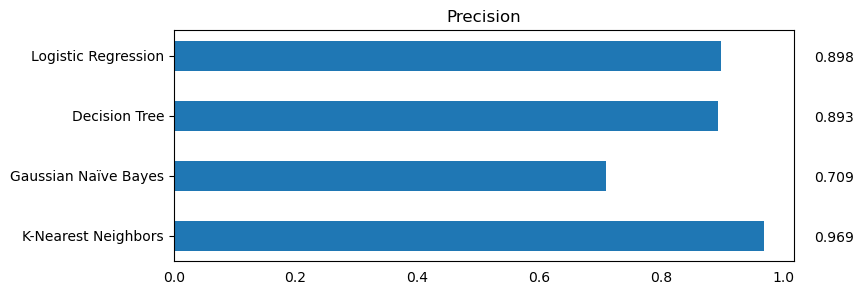

In [33]:
plot_results(model_results_df, 'Precision')

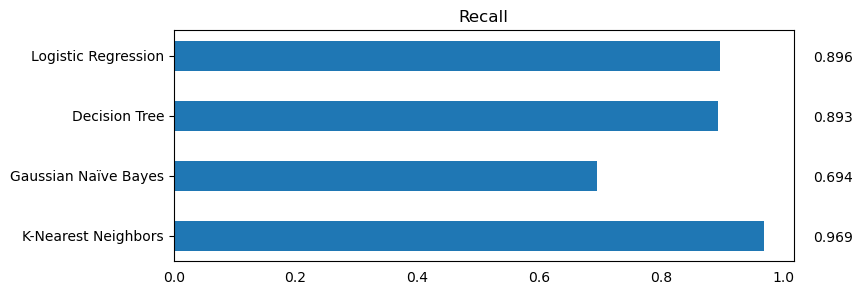

In [34]:
plot_results(model_results_df, 'Recall')

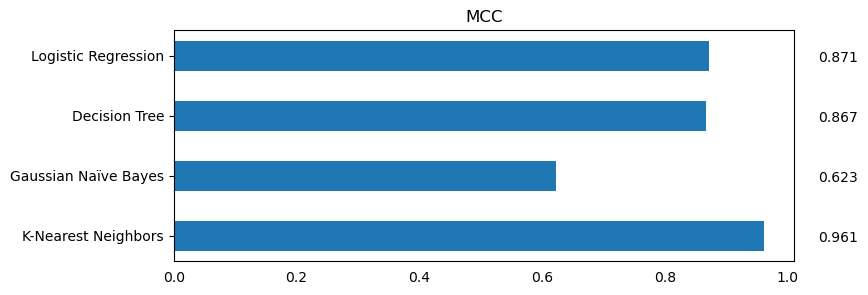

In [35]:
plot_results(model_results_df, 'MCC')

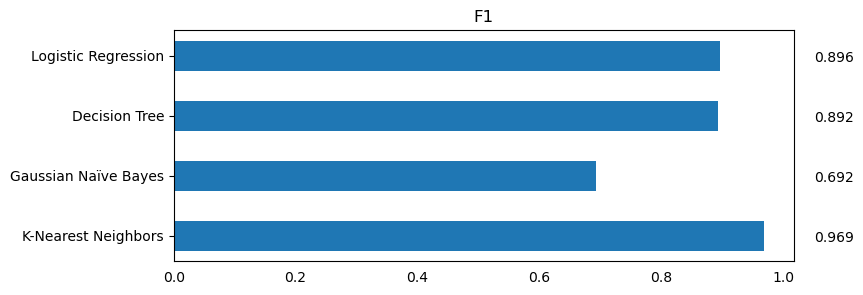

In [36]:
plot_results(model_results_df, 'F1')

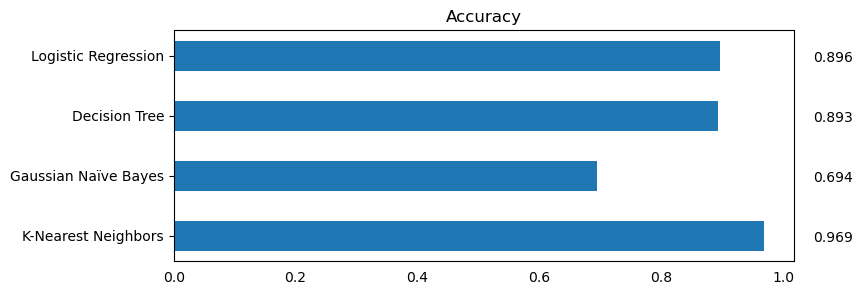

In [37]:
plot_results(model_results_df, 'Accuracy')

For the classification task of predicting the hand posture class of a given instance based on a set of features related to the x, y and z coordinates of markers on the glove fingers in a motion capture environment, the overall performance of the K-Nearest Neighbours algorithm was extremely good and superior to that obtained with either Logistic Regression, Decision Trees or Gaussian 
Naïve Bayes.

In [38]:
best_model = results_knn_df.iloc[[results_knn_df['F1'].nlargest(n=1).index[0]]]
best_model

,Model,Neighbours,Weights,Eliminated Features?,Scaler,Imputer,Precision,Recall,F1,MCC,Accuracy
61,K-Nearest Neighbors,5,distance,No,MinMaxScaler(),SimpleImputer(strategy='constant'),0.968854,0.969132,0.968666,0.961414,0.969012


In [39]:
best_model_n = int(best_model.iat[0, 1])
best_model_w = best_model.iat[0, 2]
best_model_scaler = MinMaxScaler()
best_model_imputer = SimpleImputer(strategy='constant')

This is the Confusion Matrix for the Best Performing Classification Model:


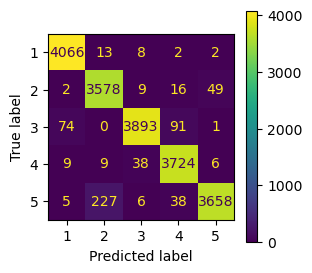

In [40]:
data = apply_preprocessor(df, best_model_scaler, best_model_imputer, x_train, x_test, y_train, y_test)
best_model = KNeighborsClassifier(n_neighbors=best_model_n, weights=best_model_w)
best_preds = get_preds(data, best_model)
print('This is the Confusion Matrix for the Best Performing Classification Model:')
fig, ax = plt.subplots(figsize=(3, 3))
cmp = ConfusionMatrixDisplay.from_predictions(y_test, best_preds, ax = ax)